In [1]:
# coding: utf-8

import io, time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn import multioutput, linear_model, ensemble, svm
from sklearn import preprocessing
import xgboost as xgb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


In [2]:
def upload_result(filename, description):
    '''
    Upload the next 48h prediction to the competition server.
    
    @filename: filename of the result, which is formatted as sample_submissioin
    '''
    
    files={"files": open(filename,"rb")}
    data = {
        "user_id": "Gakki",   #user_id is your username which can be found on the top-right corner on our website when you logged in.
        "team_token": "5d34f8aadaa604534d1024b042432e8ebf2b0009bf2b418193f7110c1f9574c3", #your team_token.
        "description": description,  #no more than 40 chars.
        "filename": filename, #your filename
    }
    url = "https://biendata.com/competition/kdd_2018_submit/"
    response = requests.post(url, files=files, data=data)
    print(response.text)
    print("If the submission is successful , you can view your submission on this page:\nhttps://biendata.com/competition/kdd_2018/my-submission/\nLeaderboard is here:\nhttps://biendata.com/competition/kdd_2018/leaderboard/")

In [3]:
def metric(true, pred, isAll=False):
    '''
    Evaluate our prediction with ground truth by SMAPE.
    
    @true: a numpy array, shape as (2304, 3)
    @pred: a numpy array, shape as (2304, 3)
    
    return: float
    '''
    print("true.shape:{}, pred.shape:{}".format(true.shape, pred.shape))
    c = np.abs(true - pred) / ((true + pred) / 2)
    c = np.nan_to_num(c)
    if isAll:
        res = c.sum() / (c.shape[0] * c.shape[1]- 13.0 * 48)
    else:
        res = c.sum() / (c.shape[0] * c.shape[1])
    print("__SMAPE: {}".format(res))
    return res


def smape(actual, predicted):
    a = np.abs(np.array(actual) - np.array(predicted))
    b = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(a, b, out=np.zeros_like(a), where=b!=0, casting='unsafe'))

In [4]:
def get_data(cit="bj", typ="air", sta="2018-04-01-0", end="2018-04-01-23"):
    '''
    Get data from the competition server. (ref: https://biendata.com/forum/view_post/9). There is no "meteorology/ld"
    
    @city: "bj" or "ld".("bj_grid" or "ld_grid" for grid data)
    @typ: "air" or "met", ("air(quality)" or "met(eorology)")
    @sta: e.g., "2018-04-01-0", 
    @end: e.g., "2018-04-01-23"
    e.g.,
    #     Air Quality data:
    #     url ="https://biendata.com/competition/airquality/bj/2018-04-01-0/2018-04-01-23/2k0d1d8"
    #     Observed Meteorology:
    #     url = "https://biendata.com/competition/meteorology/bj/2018-04-01-0/2018-04-01-23/2k0d1d8"
    #     Meteorology Grid Data:
    #     url = "https://biendata.com/competition/meteorology/bj_grid/2018-04-01-0/2018-04-01-23/2k0d1d8"
    #     Air Quality data:
    #     url = "https://biendata.com/competition/airquality/ld/2018-04-01-0/2018-04-01-23/2k0d1d8"
    #     Meteorology Grid Data:
    #     url = "https://biendata.com/competition/meteorology/ld_grid/2018-04-01-0/2018-04-01-23/2k0d1d8"
    
    return: dataframe
    '''
    if cit=="ld" and typ=="met":
        print("There is no 'meteorology/ld'!")
    else:
        url = "https://biendata.com/competition/" + ("airquality" if typ=="air" else "meteorology") + '/' + cit + '/' + sta + '/' + end + "/2k0d1d8"
        print("Get data from:", url)
        respones= requests.get(url)
#         print(respones.text)
        df = pd.read_csv(io.StringIO(respones.text))
        print("done...")
        return df

In [6]:
df = get_data(cit="bj", typ="air", sta="2018-05-26-0", end="2018-06-30-23")
df.to_csv("bj_kalalalalal.csv", index=False)

Get data from: https://biendata.com/competition/airquality/bj/2018-05-26-0/2018-06-30-23/2k0d1d8
done...


                      PM25   PM10     O3   NO2   CO   SO2
time                                                     
2018-03-31 07:00:00  105.0  172.0  127.0  53.0  0.8  14.0
2018-03-31 08:00:00   99.0  171.0  148.0  41.0  0.8  13.0
2018-03-31 09:00:00  104.0  173.0  157.0  39.0  0.8  12.0
2018-03-31 10:00:00  103.0  197.0  141.0  50.0  0.8  12.0
2018-03-31 11:00:00  128.0  213.0  135.0  56.0  0.9  14.0
2018-03-31 12:00:00  133.0  198.0  123.0  60.0  1.0  15.0


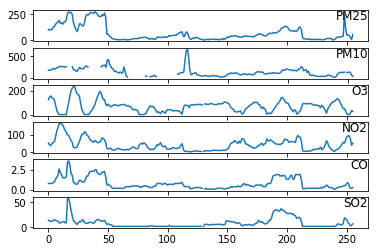

'\ndf = pd.read_csv("beijing_17_18_aq.csv")\ndf = df.sort_values(by=["station_id", "time"])\ndf["station_id"] = df["station_id"].apply(lambda x: x if len(x)<13 else x[0:10]+x[-3:])\ndf = df.reindex(columns=["id", "station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])\nstation_df = pd.DataFrame(df.loc[df["station_id"] == "dongsi_aq", ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values, index=df.loc[df["station_id"] == "dongsi_aq",:]["time"], dtype=np.float32, columns=["PM25", "PM10", "O3", "NO2", "CO", "SO2"])\nprint(station_df.head(6))\n\ngroups = ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]\ni = 1\n# plot each column\nplt.figure()\nfor group in groups:\n    plt.subplot(len(groups), 1, i)\n    plt.plot(station_df.loc["2017-03-01 01:00:00":"2017-03-31 23:00:00", group].values)\n    plt.title(group, y=0.5, loc="right")\n    i += 1\nplt.show()\n\ngroups = ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]\ni = 1\n# plot each column\nplt.figure()\nfor group in groups:\n    plt.subplot(len(g

In [12]:
# Data Visulization

df = pd.read_csv("bj_3_31-4_10.csv")
df = df.sort_values(by=["station_id", "time"])
df["station_id"] = df["station_id"].apply(lambda x: x if len(x)<13 else x[0:10]+x[-3:])
df = df.reindex(columns=["id", "station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
station_df = pd.DataFrame(df.loc[df["station_id"] == "dongsi_aq", ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values, index=df.loc[df["station_id"] == "dongsi_aq",:]["time"], dtype=np.float32, columns=["PM25", "PM10", "O3", "NO2", "CO", "SO2"])
print(station_df.head(6))

groups = ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(station_df.loc[:, group].values)
    plt.title(group, y=0.5, loc="right")
    i += 1
plt.show()

'''
df = pd.read_csv("beijing_17_18_aq.csv")
df = df.sort_values(by=["station_id", "time"])
df["station_id"] = df["station_id"].apply(lambda x: x if len(x)<13 else x[0:10]+x[-3:])
df = df.reindex(columns=["id", "station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
station_df = pd.DataFrame(df.loc[df["station_id"] == "dongsi_aq", ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values, index=df.loc[df["station_id"] == "dongsi_aq",:]["time"], dtype=np.float32, columns=["PM25", "PM10", "O3", "NO2", "CO", "SO2"])
print(station_df.head(6))

groups = ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(station_df.loc["2017-03-01 01:00:00":"2017-03-31 23:00:00", group].values)
    plt.title(group, y=0.5, loc="right")
    i += 1
plt.show()

groups = ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(station_df.loc["2017-04-01 01:00:00":"2017-04-30 23:00:00", group].values)
    plt.title(group, y=0.5, loc="right")
    i += 1
plt.show()

groups = ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(station_df.loc["2017-05-01 01:00:00":"2017-05-31 23:00:00", group].values)
    plt.title(group, y=0.5, loc="right")
    i += 1
plt.show()
'''

In [7]:
result = pd.read_csv("sample_submissioin.csv")
bj_test_station_list = list(result.iloc[i*48, 0][0:-2] for i in range(35))
bj_test_station_list = [x if len(x)<13 else x[0:10]+x[-3:] for x in bj_test_station_list]
print(bj_test_station_list)
ld_test_station_list = list(result.iloc[(35+i)*48, 0][0:-2] for i in range(13))
ld_test_station_list = [x if len(x)<13 else x[0:10]+x[-3:] for x in ld_test_station_list]
print(ld_test_station_list)

['dongsi_aq', 'tiantan_aq', 'guanyuan_aq', 'wanshouxig_aq', 'aotizhongx_aq', 'nongzhangu_aq', 'wanliu_aq', 'beibuxinqu_aq', 'zhiwuyuan_aq', 'fengtaihua_aq', 'yungang_aq', 'gucheng_aq', 'fangshan_aq', 'daxing_aq', 'yizhuang_aq', 'tongzhou_aq', 'shunyi_aq', 'pingchang_aq', 'mentougou_aq', 'pinggu_aq', 'huairou_aq', 'miyun_aq', 'yanqin_aq', 'dingling_aq', 'badaling_aq', 'miyunshuik_aq', 'donggaocun_aq', 'yongledian_aq', 'yufa_aq', 'liulihe_aq', 'qianmen_aq', 'yongdingme_aq', 'xizhimenbe_aq', 'nansanhuan_aq', 'dongsihuan_aq']
['CD1', 'BL0', 'GR4', 'MY7', 'HV1', 'GN3', 'GR9', 'LW2', 'GN0', 'KF1', 'CD9', 'ST5', 'TH4']


In [12]:
# Main procedure
# （弱智）gbr的方法

# 你需要预测北京35个站点的PM2.5，PM10和O3的浓度，以及伦敦13个站点的PM2.5和PM10的浓度。
def linear_regression(csv_file, test_station_list, offset_):
    result = np.zeros((len(test_station_list)*48, 3), dtype=np.float32)
    result_Z = np.zeros((len(test_station_list)*48, 3), dtype=np.float32)
    
    df = pd.read_csv(csv_file)
    df = df.sort_values(by=["station_id", "time"])
    df["station_id"] = df["station_id"].apply(lambda x: x if len(x)<13 else x[0:10]+x[-3:])
    df = df.reindex(columns=["id", "station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
    print(df.head(6))

    for idx, name in enumerate(test_station_list):
        print("idx: {},\tname: {}".format(idx, name))
        if "bj" in csv_file:
            station_df =pd.DataFrame(index=pd.date_range(train_time_start, predict_time_end, freq="H"), dtype=np.float32,
                                  columns=["PM25", "PM10", "O3", "NO2", "CO", "SO2"])
        else:
            station_df =pd.DataFrame(index=pd.date_range(train_time_start, predict_time_end, freq="H"), dtype=np.float32,
                                  columns=["PM25", "PM10", "NO2"])

        for ti in pd.date_range(train_time_start, predict_time_end, freq="H"):
            if str(ti) in df["time"].values:
                if "bj" in csv_file:
#                     print(ti)
#                     print(df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].iloc[:, 3:].values)
                    station_df.loc[str(ti), :] = df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values
                else:
#                     print(df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "NO2"]].values)
#                     print(station_df.loc[str(ti), :])
                    if df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "NO2"]].values.shape[0] == 0:
                        continue
                    else:
                        station_df.loc[str(ti), :] = df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "NO2"]].values
#         print(station_df)
        
        station_df = station_df.interpolate(method="linear", axis=0, limit_direction="both")
        station_df.to_csv("sub/"+name+".csv")
#         print(station_df.count())
#         plt.plot(station_df)
        
        if station_df.count().sum() == 0:
            continue
            
        s, t = 0, len(station_df.count())
        while station_df.count()[s] == 0:
            s += 1
        while station_df.count()[t-1] == 0:
            t -= 1
        print("s: {}\tt: {}".format(s, t))
        X = np.array(range(station_df.loc[train_time_start:predict_time_end, :].shape[0]), dtype=np.float32).reshape(-1, 1)
        Y = station_df.loc[train_time_start:predict_time_end, :].iloc[:, s:t].values#.reshape(-1, 1)
#         print(X.shape)
#         print(Y.shape)
        Z = np.copy(Y)
        start_time = datetime.strptime(train_time_start, "%Y-%m-%d %H:%M:%S")
        mid_time = datetime.strptime(train_time_end, "%Y-%m-%d %H:%M:%S")
        end_time = datetime.strptime(predict_time_end, "%Y-%m-%d %H:%M:%S")
        start_pos = int((mid_time-start_time) / timedelta(hours=1) + 1)
        pos = 0
        while pos < 48:
            #     model = linear_model.LinearRegression(copy_X=True)
            if "bj" in csv_file:
                model = multioutput.MultiOutputRegressor(ensemble.GradientBoostingRegressor(n_estimators=50, learning_rate=0.005, max_depth=4, random_state=0, loss="ls")) # RandomForestRegressor GradientBoostingRegressor
            else:
                model = multioutput.MultiOutputRegressor(ensemble.GradientBoostingRegressor(n_estimators=50, learning_rate=0.005, max_depth=4, random_state=0, loss="ls")) # RandomForestRegressor GradientBoostingRegressor
#             model = multioutput.MultiOutputRegressor(ensemble.RandomForestRegressor(n_estimators=50, max_depth=4, random_state=0)) # RandomForestRegressor GradientBoostingRegressor
            model.fit(X[pos:start_pos+pos], Y[pos:start_pos+pos])
            y = model.predict(np.array(X[start_pos+pos:start_pos+pos+1], dtype=np.float32))
            Y[start_pos+pos] = y[0]
            pos += 1
#             break

#         print(Y[start_pos:start_pos+pos].shape)
#         np.savetxt("sub/"+name+"_true.csv", Z[start_pos:start_pos+pos, :], delimiter=",")
#         np.savetxt("sub/"+name+"_pred.csv", Y[start_pos:start_pos+pos, :], delimiter=",")
    
#         start_pos += offset
        if "bj" in csv_file:
            result[idx*48:(idx+1)*48, :] = Y[start_pos:start_pos+pos, :3]
            result_Z[idx*48:(idx+1)*48, :] = Z[start_pos:start_pos+pos, :3]
        else:
            result[idx*48:(idx+1)*48, :2] = Y[start_pos:start_pos+pos, :2]
            result_Z[idx*48:(idx+1)*48, :2] = Z[start_pos:start_pos+pos, :2]
            
        metric(Z[start_pos:start_pos+pos], Y[start_pos:start_pos+pos])

#         break

    print(result.shape)
    return result, result_Z



train_time_start = "2018-05-29 00:00:00"
train_time_end = "2018-05-31 23:00:00"
offset_ = None
predict_time_end = "2018-06-02 23:00:00"

result_P_1, result_Z_1 = linear_regression(csv_file="bj_3_31-5_31.csv", test_station_list=bj_test_station_list, offset_=offset_)
result.iloc[0:len(bj_test_station_list)*48, 1:] = result_P_1[:, :]
print("_BJ TOTAL_: {}".format(smape(result_Z_1, result_P_1)))
# beijing: 0.632679191468254 0:8:10
# 0:9:11 0.7954752604166667/1:9:11 0.7381301637679811/2:9:11 0.6979181198846727/3:9:11 0.721686275421627/

result_P_2, result_Z_2 = linear_regression(csv_file="ld_3_31-5_31.csv", test_station_list=ld_test_station_list, offset_=offset_)
result.iloc[len(bj_test_station_list)*48:, 1:] = result_P_2[:, :]
# print(result_P_2.shape)
print("_LD TOTAL_: {}".format(smape(result_Z_2, result_P_2)))
# ld: 0.3679184220794939
# 0:9:11 0.532379639454377/1:9:11 0.5169988452878773/2:9:11 0.4945026625934829/3:9:11 0.4671823224450788/

print("_ALL TOTAL_: {}".format(smape(np.concatenate((result_Z_1, result_Z_2), axis=0), np.concatenate((result_P_1, result_P_2), axis=0))))
# 0.6166422215430184
# 0:9:11 0.7960894635615458/1:9:11 0.7455467631798665/2:9:11 0.7066183696873012/3:9:11 0.7175356644103849/
# 4-11.csv', "lr", 5:11:13, 0.41452772352430556, 0.19419955392169136, 0.39007017023994117/
# 4:11:13 0.42819688585069443,0.20843140691773504,0.4052633426268289/3:11:13 0.4245962960379464,0.22757735619178185,0.40807732734971375/
# 4-13.csv, "lr", 7:13:15 0.48,0.07,0.41;0.5944488040984623,0.292759039463141,0.5636238699954278:leader board 0.544725280843/
# 4-14.csv, "lr", 8:14:16 0.65,0.33,0.62;0.5991676451667907,0.4604254176474025,0.6173220724246581/4-14-1.csv 7:14:16 0.66,0.35,0.63/4-14-2.csv 9:14:16 0.62,0.31,0.59;0.6096156044611856,0.47813050359742254,0.630967390142931/
# 4-15.csv, "lr", 9:15:17 0.62,0.62;0.728452881480598/4-15-1.csv 10:15:17 0.68,0.44,0.68;0.7341872353590172/4-15-2.csv 8:15:17 0.66,0.42,0.66/
# 4-16.csv “gbr”, 10:16:18 0.50,0.45,0.54;0.6905676463293651,0.5057563781738281,0.7040771018457777;0.711939568569/14:16:18 0.530359371124752,0.35671768840561563,0.5312956210614465/12:16:18 0.61997559562562,0.45122012929019767,0.6312596755476702/
# 4-17.csv, "gbr", 11:17:19 0.52,0.35,0.52;0.564759106248/4-17-1.csv, 9:17:19 0.57,0.41,0.58;0.593427019657/
# 4-18.csv, "gbr", 12:18:20 0.58,0.35,0.57;0.413003513872/14:18:20 0.49,0.46,0.53;0.464856744682/16:18:20 0.42,0.48,0.48;0.464856744682/
# 4-19.csv, "gbr", 13:19:21 0.47,0.15,0.42;0.443111704138/4-19-1.csv 15:19:21 /4-19-2.csv 17:19:21 /

# 4-22.csv, "gbr", 16:22:24 1.08,0.72,1.08/18:22:24 1.02,0.74,1.04/01:22:24 0.95,0.69,0.96
# 4-23.csv, "gbr", 17:23:25 1.15,0.63,1.11;0.898565600354/4-23-1.csv 19:23:25 0.93,0.63,0.93/4-23-2.csv 21:23:25 0.60,0.51,0.63/4-23-3.csv 12:23:25 1.14,0.62,1.10
# 4-24.csv, "gbr", 18:24:26 0.89,0.66,0.91;0.761868195043/4-24-1.csv, "gbr", 20:24:26 0.73,0.57,0.76;0.79664564954/4-24-2.csv, "gbr", 22:24:26 0.72,0.24,0.65;0.597818114678/
# 4-25.csv, "gbr", 19:25:27 0.75,0.58,0.78;0.610632147558/4-25-1.csv, "gbr", 21:25:27 0.97,0.37,0.89;0.596734856492/4-25-2.csv, "gbr", 23:25:27 0.83,0.15,0.71;0.513163940279/
# 4-26.csv, "gbr", 20:26:28 0.75,0.36,0.71;0.605642161477/4-26-1.csv, 22:26:28 0.72,0.15,0.62;0.540524302618/4-26-2.csv, 24:26:28 0.69,0.14,0.60;0.506199629764/
# 4-27.csv, "gbr", 21:27:29 0.67,0.18,0.59;0.625253145078/4-27-1.csv, 23:27:29 0.61,0.21,0.55;0.531537960925/4-27-2.csv, 25:27:29 ,,/
# 4-28.csv, "gbr", 22:28:30 0.72,0.17,0.63;0.501283379849/4-28-1.csv, 24:28:30 0.65,0.15,0.57;0.50738618143/4-28-2.csv, 26:28:30 0.61,0.17,0.54;0.573443060786/
# 4-29.csv, "gbr", 23:29:01 0.77,0.17,0.67;0.519411822456/4-29-1.csv, 25:29:01 0.89,0.17,0.76/4-29-2.csv, 21:29:01 0.66,0.25,0.60;0.527372635447/4-29-3.csv, 27:29:01 0.96,0.18,0.82;0.60696802997/
# 4-30.csv, "gbr", 24:30:02 0.77,0.23,0.68;0.561735815585/4-30-1.csv, 26:30:02 0.81,0.23,0.72;0.622201486256/4-30-2.csv, 28:30:02 0.74,0.30,0.68/

# 5-3.csv, "gbr", 27:03:05 0.79,0.25,0.71;0.562405120188/5-3-1.csv, "gbr", 29:03:05 0.65,0.23,0.59;0.643277245105/5-3-2.csv, "gbr", 01:03:05 0.73,0.18,0.64;0.71344008538/
# 5-4.csv, "gbr", 28:04:06 0.52,0.37,0.53;0.660361370454;0.49,0.55,0.51/5-4-1, 01:04:06 0.66,0.26,0.60;0.646978116034/5-4-2, 02:04:06 0.58,0.18,0.52/5-4-3, 03:04:06 0.45,0.12,0.39;0.51343560274/
# 5-5.csv, "gbr", 29:05:07 0.70,0.53,0.65;0.648592260228/5-5-1, 01:05:07 0.70,0.44,0.63;0.600624733882/5-5-2, 03:05:07 ,,;0.511269753812/5-4-3, 03:04:06 0.68,0.27,0.57/
# 5-6.csv, "gbr", 30:06:08 0.47,0.51,0.48;0.596458405424/5-6-1, 20:06:08 0.52,0.58,0.53;0.58725396237/5-6-2, 04:06:08 0.61,0.25,0.51;0.587376549612/
# 5-7.csv, "gbr", 01:07:09 0.84,0.31,0.69;0.50150214231/5-7-1, 03:07:09 0.96,0.20,0.75;0.587383953135/5-7-2, 05:07:09 0.90,0.12,0.69;0.613817718495/5-7-3, 22:07:09, 0.84,0.54,0.76;/
# 5-8.csv, "gbr", 02:08:10 0.70,0.53,0.65;0.585950661184/5-8-1, 04:08:10 0.74,0.54,0.69;0.666918263653/5-8-2, 06:08:10 0.61,0.54,0.59;0.724131857718/
# 5-9.csv, "gbr", 03:09:11 0.62,0.40,0.53;0.567786884472/5-9-1, 05:09:11 0.60,0.44,0.56;/5-9-2, 07:09:11 0.64,0.34,0.56;0.552699548196/ 
# 5-10.csv, "gbr", 04:10:12 0.30,0.45,0.34;0.574106251635/5-10-1, 06:10:12 0.28,0.42,0.32;0.542870054063/5-10-2, 08:10:12 0.29,0.58,0.37;0.412210106414/ 
# 5-11
# 5-12.csv, "gbr", 06:12:14 1.00,0.59,0.89;0.48948527779/5-12-1, 08:12:14 1.05,0.24,0.83;/5-12-2, 10:12:14 1.06,0.21,0.83;/
# 5-13.csv, "gbr", 07:13:15 0.54,0.06,0.41;0.480310708338/5-13-1, 09:13:15 0.49,0.25,0.42;0.480310708338/5-13-2, 11:13:15 0.50,0.22,0.42;0.480310708338/
# 5-14.csv, "gbr", 08:14:16 0.52,1.96,0.91;0.387165103261/5-14-1, 10:14:16 0.55,0.34,0.49;0.384526841605/5-14-2, 12:14:16 0.56,0.33,0.50;0.396572753638/
# 5-15.csv, "gbr", 09:15:17 0.51,0.29,0.45;0.560279202824/5-15-1, 11:15:17 0.48,0.29,0.43;0.557097115187/5-15-2, 13:15:17 0.45,0.18,0.38;0.563205487944/
# 5-16.csv, "gbr", 10:16:18 0.51,0.37,0.48;0.581721631259/5-16-1, 12:16:18 0.50,0.17,0.41;0.566897558171/5-16-2, 14:16:18 0.46,0.11,0.36;0.553854467292/
# 5-17.csv, "gbr", 11:17:19 1.00,0.14,0.77;0.472822783035/5-17-1, 13:17:19 0.97,0.11,0.74;0.477915185074/5-17-2, 15:17:19 0.81,0.09,0.61;0.442905975663/
# 5-18.csv, "gbr", 12:18:20 0.69,0.22,0.56;0.462458944617/5-18-1, 14:18:20 0.63,0.21,0.52;0.461196064771/5-18-2, 16:18:20 0.59,0.19,0.48;0.42063323312/
# 5-19.csv, "gbr", 13:19:21 0.47,0.20,0.39;0.53379543216/5-19-1, 15:19:21 0.39,0.16,0.32;0.484690476323/5-19-2, 17:19:21 0.35,0.11,0.28;0.443347173062/
# 5-20.csv, "gbr", 14:20:22 0.47,0.39,0.45;0.567822481135/5-20-1, 16:20:22 0.51,0.34,0.46;0.534707085536/5-20-2, 18:20:22 0.49,0.26,0.43;0.495825982071/
# 5-21.csv, "gbr", 15:21:23 0.54,0.17,0.44;0.43674030411/5-21-1, 17:21:23 0.51,0.13,0.40;0.448593387477/5-21-2, 19:21:23 0.43,0.10,0.34;0.505623178469/
# 5-22.csv, "gbr", 16:22:24 0.86,0.08,0.65;0.371830048014/5-22-1, 18:22:24 0.82,0.10,0.62;0.391381743006/5-22-2, 20:22:24 0.69,0.13,0.54;0.391381743006/
# 5-23.csv, "gbr", 17:23:25 0.58,0.07,0.44;0.421625146546/5-23-1, 19:23:25 0.58,0.09,0.45;0.388164737048/5-23-2, 21:23:25 0.64,0.07,0.49;0.415952495474/
# 5-24.csv, "gbr", 18:24:26 0.35,0.22,0.32;0.472619993925/5-24-1, 20:24:26 0.39,0.23,0.35;0.428721343454/5-24-2, 22:24:26 0.48,0.22,0.41;0.435727952713/
# 5-25.csv, "gbr", 19:25:27 0.55,0.32,0.49;0.45678940295/5-25-1, 21:25:27 0.58,0.32,0.51;0.460283432248/5-25-2, 23:25:27 0.56,0.28,0.49;0.442126721305/
# 5-26.csv, "gbr", 20:26:28 0.60,0.15,0.48;0.535109121749/5-26-1, 22:26:28 0.64,0.13,0.50;0.541254438108/5-26-2, 24:26:28 0.68,0.06,0.51;0.537746849721/
# 5-27.csv, "gbr", 21:27:29 0.93,0.27,0.74;/5-27-1, 23:27:29 0.94,0.23,0.75;/5-27-2, 25:27:29 0.86,0.24,0.69;/
# 5-28.csv, "gbr", 22:28:30 1.23,0.15,0.94;/5-28-1, 24:28:30 1.23,0.16,0.94;/5-28-2, 26:28:30 1.16,0.14,0.89;/
# 5-29.csv, "gbr", 23:29:31 0.94,0.24,0.75;/5-29-1, 25:29:31 0.95,0.28,0.77;/5-29-2, 27:29:31 0.76,0.28,0.63;/
# 5-30.csv, "gbr", 24:30:01 0.65,0.23,0.54;/5-30-1, 26:30:01 0.63,0.23,0.52;/5-30-2, 28:30:01 0.87,0.27,0.70;/
# 5-31.csv, "gbr", 25:31:02 0.61,0.23,0.51;/5-31-1, 27:31:02 0.61,0.24,0.51;/5-31-2, 29:31:02 0.66,0.20,0.54;/









          id     station_id                 time   PM25   PM10     O3   NO2  \
4    2941454  aotizhongx_aq  2018-03-31 07:00:00  117.0  166.0  111.0  67.0   
39   2941530  aotizhongx_aq  2018-03-31 08:00:00  109.0  161.0  126.0  57.0   
74   2941586  aotizhongx_aq  2018-03-31 09:00:00  119.0  181.0  133.0  58.0   
109  2941642  aotizhongx_aq  2018-03-31 10:00:00  127.0  198.0  123.0  64.0   
144  2941698  aotizhongx_aq  2018-03-31 11:00:00   83.0  221.0  118.0  69.0   
179  2941754  aotizhongx_aq  2018-03-31 12:00:00  135.0  200.0   79.0  91.0   

      CO   SO2  
4    0.8  14.0  
39   0.8  14.0  
74   0.7  13.0  
109  0.8  12.0  
144  0.8  14.0  
179  1.0  13.0  
idx: 0,	name: dongsi_aq
s: 0	t: 6
true.shape:(48, 6), pred.shape:(48, 6)
__SMAPE: 0.8691776593526205
idx: 1,	name: tiantan_aq
s: 0	t: 6
true.shape:(48, 6), pred.shape:(48, 6)
__SMAPE: 0.653777281443278
idx: 2,	name: guanyuan_aq
s: 0	t: 6
true.shape:(48, 6), pred.shape:(48, 6)
__SMAPE: 0.7385935253567166
idx: 3,	name: wanshoux

In [13]:


result.to_csv("5-31-2.csv", index=False)
upload_result('5-31-2.csv', "gbr, 29:31:02")

{"success": true}
If the submission is successful , you can view your submission on this page:
https://biendata.com/competition/kdd_2018/my-submission/
Leaderboard is here:
https://biendata.com/competition/kdd_2018/leaderboard/


In [10]:

no_zero = pd.read_csv("5-18.csv")
print(no_zero.head())
no_zero.iloc[:, 1:] = np.abs(no_zero.iloc[:, 1:])
no_zero.to_csv("5-18.csv", index=False)



       test_id      PM2.5        PM10          O3
0  dongsi_aq#0  96.378571  101.023598  112.467293
1  dongsi_aq#1  96.394211  100.814186  112.733292
2  dongsi_aq#2  96.343796  100.615097  112.934158
3  dongsi_aq#3  96.235596  100.396805  113.023682
4  dongsi_aq#4  96.110443  100.149803  112.979721


In [22]:
# Main procedure
# LSTM

csv_file = "bj_3_31-4_10.csv"

train_time_start = "2018-03-31 07:00:00"
train_time_end = "2018-04-08 23:00:00"
predict_time_end = "2018-04-10 23:00:00"

df = pd.read_csv(csv_file)
df = df.sort_values(by=["station_id", "time"])
df["station_id"] = df["station_id"].apply(lambda x: x if len(x)<13 else x[0:10]+x[-3:])
df = df.reindex(columns=["id", "station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
# print(df.head(6))
given_station_list = list(set(df["station_id"]))
print(given_station_list)
new_df = pd.DataFrame(dtype=np.float32, columns=["station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])

for idx, name in enumerate(given_station_list):
    print("idx: {},\tname: {}".format(idx, name))
    station_df =pd.DataFrame(index=pd.date_range(train_time_start, predict_time_end, freq="H"), dtype=np.float32,
                              columns=["station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
    for ti in pd.date_range(train_time_start, predict_time_end, freq="H"):
        if str(ti) in df["time"].values:
#             print(str(ti))
#             print(df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values)
            station_df.loc[str(ti), "PM25":"SO2"] = df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values
#             print(station_df.loc[str(ti), :])
    station_df.loc[:, "station_id"] = name
    station_df.loc[:, "time"] = pd.date_range(train_time_start, predict_time_end, freq="H")
#     print(station_df)
    station_df = station_df.interpolate(method="linear", axis=0, limit_direction="both")
#     print(station_df.count())
    new_df = new_df.append(station_df, ignore_index=True)
#     break

print(new_df.count())

['qianmen_aq', 'wanshouxig_aq', 'wanliu_aq', 'aotizhongx_aq', 'guanyuan_aq', 'fangshan_aq', 'zhiwuyuan_aq', 'dongsi_aq', 'beibuxinqu_aq', 'gucheng_aq', 'miyunshuik_aq', 'badaling_aq', 'fengtaihua_aq', 'yongledian_aq', 'yufa_aq', 'huairou_aq', 'tiantan_aq', 'yanqin_aq', 'nongzhangu_aq', 'tongzhou_aq', 'daxing_aq', 'dongsihuan_aq', 'xizhimenbe_aq', 'yongdingme_aq', 'nansanhuan_aq', 'yungang_aq', 'dingling_aq', 'donggaocun_aq', 'liulihe_aq', 'mentougou_aq', 'miyun_aq', 'pingchang_aq', 'pinggu_aq', 'shunyi_aq', 'yizhuang_aq']
idx: 0,	name: qianmen_aq
idx: 1,	name: wanshouxig_aq
idx: 2,	name: wanliu_aq
idx: 3,	name: aotizhongx_aq
idx: 4,	name: guanyuan_aq
idx: 5,	name: fangshan_aq
idx: 6,	name: zhiwuyuan_aq
idx: 7,	name: dongsi_aq
idx: 8,	name: beibuxinqu_aq
idx: 9,	name: gucheng_aq
idx: 10,	name: miyunshuik_aq
idx: 11,	name: badaling_aq
idx: 12,	name: fengtaihua_aq
idx: 13,	name: yongledian_aq
idx: 14,	name: yufa_aq
idx: 15,	name: huairou_aq
idx: 16,	name: tiantan_aq
idx: 17,	name: yanqin_

In [39]:
# new_df.to_csv("new_df.csv")
# new_df = new_df.sort_values(by=["time", "station_id"])
# print(new_df.count())
# print(new_df.head(6))

np.random.seed(2)
torch.manual_seed(2)

def create_dataset(data, back=2, forward=1):
    print("input.shape: {}, back: {}, forward: {}".format(data.shape, back, forward))
    total_num = data.shape[0]-back-forward+1
    train = np.zeros((total_num, back, data.shape[1]), dtype=np.float32)
    # TODO: /6*3
    test = np.zeros((total_num, forward, data.shape[1]), dtype=np.float32)
    for i in range(total_num):
        train[i, :, :] = data[i : i+back, :]
        test[i, :, :] = data[i+back : i+back+forward, :]

#     test = np.concatenate((test[:, :, 0::6].reshape(test.shape[0], test.shape[1], 1, -1), test[:, :, 1::6].reshape(test.shape[0], test.shape[1], 1, -1), test[:, :, 2::6].reshape(test.shape[0], test.shape[1], 1, -1)), axis=2).reshape((test.shape[0], test.shape[1], -1), order='F')
    print("train.shape: {}".format(train.shape))
    print("test.shape: {}".format(test.shape))
    return train, test


def get_prediction(model, init_data, forward=1):
    pass




time_series_df =pd.DataFrame(index=pd.date_range(train_time_start, predict_time_end, freq="H"), columns=range(35*6), dtype=np.float32)

for ti in pd.date_range(train_time_start, predict_time_end, freq="H"):
    time_series_df.loc[str(ti), :] = new_df.loc[new_df["time"]==str(ti), "PM25":"SO2"].values.reshape(1, -1)
#     break

# print(time_series_df.head(6))

scaler_6 = preprocessing.MinMaxScaler(feature_range=(0, 1)) # RobustScaler MinMaxScaler(feature_range=(0, 1))
scaler_3 = preprocessing.MinMaxScaler(feature_range=(0, 1)) # RobustScaler MinMaxScaler(feature_range=(0, 1))
# scaled_dataset = scaler.fit_transform(time_series_df.fillna(0).values)

train, test = create_dataset(time_series_df.fillna(0).values)
train = scaler.fit_transform(train.reshape(train.shape[0], -1)).reshape(train.shape[0], 2, -1)
test = scaler.fit_transform(test.reshape(test.shape[0], -1)).reshape(test.shape[0], 1, -1)

# train, test = create_dataset(scaled_dataset)


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(x, hidden_state)
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out, hidden_state


train = Variable(torch.FloatTensor(train))
test = Variable(torch.FloatTensor(test))

hidden_size = 64
num_layers = 2
dropout = 0.2
learning_rate = 0.01
weight_decay = 5e-4

rnn = RNN(train.size(2), hidden_size, num_layers, test.size(2), dropout)
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_func = nn.MSELoss()

num_epochs = 30

for epoch in range(num_epochs):

    rnn.train()
    optimizer.zero_grad()
    
    hidden_state = (Variable(torch.zeros(num_layers, train[:-48, :, :].size(0), hidden_size)), Variable(torch.zeros(num_layers, train[:-48, :, :].size(0), hidden_size)))
    outputs, _ = rnn(train[:-48, :, :], hidden_state)
    loss = loss_func(outputs, test[:-48, :, :])

    loss.backward()
    optimizer.step()
#     print(outputs)
#     print(scaler_3.inverse_transform(outputs.data.numpy().reshape(-1, 105)))
#     print(scaler_3.inverse_transform(test.data.numpy().reshape(-1, 105)))
    print(outputs.data.numpy().reshape(outputs.size(0), -1).shape)
    example = scaler_6.inverse_transform(outputs.data.numpy().reshape(outputs.size(0), -1)).reshape(outputs.size(0), 1, -1)
    example = np.concatenate((example[:, :, 0::6].reshape(example.shape[0], example.shape[1], 1, -1), example[:, :, 1::6].reshape(example.shape[0], example.shape[1], 1, -1), example[:, :, 2::6].reshape(example.shape[0], example.shape[1], 1, -1)), axis=2).reshape((example.shape[0], example.shape[1], -1), order='F')
    pred = example
    print(pred.shape)
    example = scaler_6.inverse_transform(test[:-48, :, :].data.numpy().reshape(test[:-48, :, :].size(0), -1)).reshape(test[:-48, :, :].size(0), 1, -1)
    example = np.concatenate((example[:, :, 0::6].reshape(example.shape[0], example.shape[1], 1, -1), example[:, :, 1::6].reshape(example.shape[0], example.shape[1], 1, -1), example[:, :, 2::6].reshape(example.shape[0], example.shape[1], 1, -1)), axis=2).reshape((example.shape[0], example.shape[1], -1), order='F')
    true = example
    print(true.shape)
    metric(true.reshape(true.size(0), -1), pred.reshape(pred.size(0), -1))
    print("Epoch: {:04d}".format(epoch + 1), "mse_loss: {:.4f}".format(loss.data[0]))
#     break


'''
pred_res = np.zeros((48, 3*35), dtype=np.float32)
for i in range(48):
    rnn.test()
    hidden_state = (Variable(torch.zeros(num_layers, train.size(0), hidden_size)), Variable(torch.zeros(num_layers, train.size(0), hidden_size)))
    outputs, _ = rnn(train[i-48, :, :], hidden_state)
    pred_res[i] = outputs.data.numpy().reshape(1, -1)
''' 




input.shape: (257, 210), back: 2, forward: 1
train.shape: (255, 2, 210)
test.shape: (255, 1, 210)
(207, 210)
(207, 1, 105)
(207, 1, 105)


TypeError: 'int' object is not callable

In [4]:
# Main procedure
# Stacking/boosting

csv_file = "bj_3_31-4_10.csv"

train_time_start = "2018-04-01 00:00:00"
train_time_end = "2018-04-17 23:00:00"
predict_time_end = "2018-04-19 23:00:00"

df = pd.read_csv(csv_file)
df = df.sort_values(by=["station_id", "time"])
df["station_id"] = df["station_id"].apply(lambda x: x if len(x)<13 else x[0:10]+x[-3:])
df = df.reindex(columns=["id", "station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
given_station_list = list(set(df["station_id"]))
print(given_station_list)
new_df = pd.DataFrame(dtype=np.float32, columns=["station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
new_df_y = pd.DataFrame(dtype=np.float32, columns=["station_id", "time", "PM25", "PM10", "O3"])

for idx, name in enumerate(given_station_list):
    print("idx: {},\tname: {}".format(idx, name))
    station_df =pd.DataFrame(index=pd.date_range(train_time_start, predict_time_end, freq="H"), dtype=np.float32,
                              columns=["station_id", "time", "PM25", "PM10", "O3", "NO2", "CO", "SO2"])
    for ti in pd.date_range(train_time_start, predict_time_end, freq="H"):
        if str(ti) in df["time"].values:
#             print(str(ti))
#             print(df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values)
            station_df.loc[str(ti), "PM25":"SO2"] = df.loc[(df["station_id"] == name)&(df["time"] == str(ti)), :].loc[:, ["PM25", "PM10", "O3", "NO2", "CO", "SO2"]].values
#             print(station_df.loc[str(ti), :])
    station_df.loc[:, "station_id"] = name
    station_df.loc[:, "time"] = pd.date_range(train_time_start, predict_time_end, freq="H")
#     print(station_df)
    station_df = station_df.interpolate(method="linear", axis=0, limit_direction="both")
#     print(station_df.count())
    new_df = new_df.append(station_df, ignore_index=True)
    new_df_y = new_df_y.append(station_df.loc[:, "station_id":"O3"], ignore_index=True)
#     break

print(new_df.count())



['miyunshuik_aq', 'fangshan_aq', 'miyun_aq', 'yongdingme_aq', 'huairou_aq', 'guanyuan_aq', 'zhiwuyuan_aq', 'beibuxinqu_aq', 'badaling_aq', 'tiantan_aq', 'yanqin_aq', 'nansanhuan_aq', 'pingchang_aq', 'yungang_aq', 'donggaocun_aq', 'nongzhangu_aq', 'liulihe_aq', 'dongsihuan_aq', 'wanshouxig_aq', 'yongledian_aq', 'pinggu_aq', 'gucheng_aq', 'mentougou_aq', 'yufa_aq', 'fengtaihua_aq', 'aotizhongx_aq', 'qianmen_aq', 'wanliu_aq', 'tongzhou_aq', 'shunyi_aq', 'yizhuang_aq', 'dongsi_aq', 'daxing_aq', 'dingling_aq', 'xizhimenbe_aq']
idx: 0,	name: miyunshuik_aq
idx: 1,	name: fangshan_aq
idx: 2,	name: miyun_aq
idx: 3,	name: yongdingme_aq
idx: 4,	name: huairou_aq
idx: 5,	name: guanyuan_aq
idx: 6,	name: zhiwuyuan_aq
idx: 7,	name: beibuxinqu_aq
idx: 8,	name: badaling_aq
idx: 9,	name: tiantan_aq
idx: 10,	name: yanqin_aq
idx: 11,	name: nansanhuan_aq
idx: 12,	name: pingchang_aq
idx: 13,	name: yungang_aq
idx: 14,	name: donggaocun_aq
idx: 15,	name: nongzhangu_aq
idx: 16,	name: liulihe_aq
idx: 17,	name: don

In [57]:
# print(new_df)
# print(new_df_y)

def make_dataset(in_x, in_y):
    assert in_x.shape[0] == in_y.shape[0]
    tmp_X, tmp_Y = [], []
    days_num = int(in_x.shape[0] / 24)
    print("days_num:", days_num)
    for i in range(days_num-3):
        tmp_X.append(in_x[i*24:(i+2)*24, :])
        j = i + 2
        tmp_Y.append(in_y[j*24:(j+2)*24, :])
    tmp_X = np.asarray(tmp_X, dtype=np.float32)
    tmp_Y = np.asarray(tmp_Y, dtype=np.float32)
    train_X = tmp_X[:-1, :].reshape(tmp_X[:-1, :].shape[0], -1)
    train_Y = tmp_Y[:-1, :].reshape(tmp_Y[:-1, :].shape[0], -1)
    test_X = tmp_X[-1:, :].reshape(1, -1)
    test_Y = tmp_Y[-1:, :].reshape(1, -1)
    return train_X, train_Y, test_X, test_Y


new_df = new_df.fillna(0)
new_df_y = new_df_y.fillna(0)

dataset_X = pd.DataFrame(index=pd.date_range(train_time_start, predict_time_end, freq="H"), columns=range(35*6), dtype=np.float32)
dataset_Y = pd.DataFrame(index=pd.date_range(train_time_start, predict_time_end, freq="H"), columns=range(35*3), dtype=np.float32)
for ti in pd.date_range(train_time_start, predict_time_end, freq="H"):
    dataset_X.loc[str(ti), :] = new_df.loc[new_df["time"] == str(ti), :].loc[:, "PM25":"SO2"].values.reshape(1, -1)
    dataset_Y.loc[str(ti), :] = new_df_y.loc[new_df["time"] == str(ti), :].loc[:, "PM25":"O3"].values.reshape(1, -1)

scaler_train = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
print(dataset_X.values.shape)
print(dataset_Y.values.shape)
train_X, train_Y, test_X, test_Y = make_dataset(scaler_train.fit_transform(dataset_X.values), scaler_test.fit_transform(dataset_Y.values))
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(456, 105)
days_num: 19
(15, 10080)
(15, 5040)
(1, 10080)
(1, 5040)


In [103]:
'''
multioutput.MultiOutputRegressor(estimator)

ensemble.AdaBoostRegressor([base_estimator, …])
ensemble.ExtraTreesRegressor([n_estimators, …])
ensemble.GradientBoostingRegressor([loss, …])
ensemble.RandomForestRegressor([…])
svm.SVR([kernel, degree, gamma, coef0, tol, …])
'''
random_state=0

ada = ensemble.AdaBoostRegressor(
    n_estimators=500,
    learning_rate=0.75,
    random_state=random_state)
et = ensemble.ExtraTreesRegressor(
    n_jobs=-1,
    n_estimators=500,
    # max_features=0.5,
    max_depth=8,
    min_samples_leaf=2,
    verbose=0,
    random_state=random_state)
gbr = ensemble.GradientBoostingRegressor(
    n_estimators=20,
    learning_rate=0.005,
    max_depth=3,
    loss='ls',
    max_features=0.2,
    verbose=0,
    random_state=random_state)
rf = ensemble.RandomForestRegressor(
    n_jobs=-1,
    n_estimators=500,
    warm_start=True, 
    # max_features=0.2,
    max_depth=6,
    min_samples_leaf=2,
    max_features='sqrt',
    verbose=0,
    random_state=random_state)
svr = svm.SVR(
    kernel='linear',
    C=0.025,
    epsilon=0.1,
    verbose=False)

t1 = time.time()

model = multioutput.MultiOutputRegressor(gbr)



model.fit(train_X, train_Y)


print("training time:", time.time()-t1)

y = model.predict(test_X)

metric(scaler_test.inverse_transform(test_Y.reshape(48, -1)), scaler_test.inverse_transform(y.reshape(48, -1)))

output = scaler_test.inverse_transform(y.reshape(48, -1)).reshape(48, 35, 3)
output = np.swapaxes(output, 0, 1).reshape(-1, 3)
print(output.shape)


KeyboardInterrupt: 